# Machine Translation + Transformer

<img src = "../figures/transformer1.png" >

In [1147]:
# !pip install torchdata
# !pip install torch==2.2.0 torchtext==0.17.0

In [1148]:
# !pip install datasets
# !pip install pyidaungsu

In [1149]:
import torch, torchdata, torchtext
import torch.nn as nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cuda


In [1150]:
# torch.cuda.get_device_name(0)

In [1151]:
torch.__version__

'2.2.0+cu121'

In [1152]:
torchtext.__version__

'0.17.0+cpu'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [1153]:
from datasets import load_dataset, Dataset
import pandas as pd
import re
import pyidaungsu

In [1154]:
# # Load dataset from Hugging Face
# dataset = load_dataset("simbolo-ai/hola")

In [1155]:
# # Convert to pandas dataframe
# df = dataset['train'].to_pandas()

In [1156]:
# # Filter for English (en) and Burmese (my) texts
# df_en = df[df['label'] == 'en'].reset_index(drop=True)
# df_my = df[df['label'] == 'my'].reset_index(drop=True)

In [1157]:
# # en and my alignment
# df_aligned = pd.DataFrame({
#     "English": df_en["text"].values,
#     "Burmese": df_my["text"].values
# })

In [1158]:
# def preprocess_text(text, language="en"):
#     text = text.lower().strip()  # Lowercasing & trimming spaces

#     if language == "my":  # For Burmese
#         text = re.sub(r"[^a-zA-Zက-အ0-9\s]", "", text)  # Remove special characters but keep Burmese characters
#     else:
#         text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters for non-Burmese languages

#     return text  # Return full, unsegmented text

In [1159]:
# # Save to CSV for further processing
# df_aligned.to_csv("data/processed_translation_data.csv", index=False)

In [1160]:
# # Initialize Pyidaungsu tokenizer
# tokenizer = pyidaungsu.Tokenize()

In [1161]:
# # Preprocessing function
# def preprocess_text(text, language="en"):
#     text = text.lower().strip()  # Lowercasing & trimming spaces
#     text = re.sub(r"[^a-zA-Zက-အ0-9\s]", "", text)  # Remove special characters
#     if language == "my":
#         text = " ".join(tokenizer.tokenize(text))  # Tokenize Burmese text
#     return text

In [1162]:
# # Apply preprocessing
# df_aligned["English"] = df_aligned["English"].apply(lambda x: preprocess_text(x, "en"))
# df_aligned["Burmese"] = df_aligned["Burmese"].apply(lambda x: preprocess_text(x, "my"))

# Save to CSV for further processing
# df_aligned.to_csv("data/processed_translation_data.csv", index=False)

In [1163]:
# df_aligned.head()

In [1164]:
# Load the preprocessed dataset
df = pd.read_csv("data/processed_translation_data.csv")
train_df = Dataset.from_pandas(df)

In [1165]:
type(train_df)

datasets.arrow_dataset.Dataset

In [1166]:
train = [(row['English'], row['Burmese']) for row in train_df]

In [1167]:
train[0]

('Human evolution is the evolutionary process within the history of primates that led to the emergence of Homo sapiens as a distinct species of the hominid family, which includes all the great apes',
 'ဇီဝဗေဒ ပညာတွင် ဆင့်ကဲပြောင်းလဲမှုဖြစ်စဉ် သို့မဟုတ် အီဗော်လူးရှင်း ဆိုသည်မှာ သက်ရှိအစုအဝေးများတွင် တွေ့ရသော မျိုးရိုးလိုက်သည့် လက္ခဏာရပ်များ အချိန်နှင့် အမျှ ပြောင်းလဲသွားခြင်းကို ခေါ်ဆိုခြင်း ဖြစ်သည်')

In [1168]:
# train_dataset = Dataset.from_pandas(df)

In [1169]:
# type(train_dataset)

In [1170]:
# type(train_dataset)

In [1171]:
# df.head()

In [1172]:
# !pip install portalocker>=2.0.0
# import portalocker

In [1173]:
# from torchtext.datasets import Multi30k
# from torchtext.data.utils import get_tokenizer
# from torchtext.vocab import build_vocab_from_iterator
# from torch.nn.utils.rnn import pad_sequence
# from torch.utils.data import DataLoader

In [1174]:
# from torchtext.datasets import Multi30k

# SRC_LANGUAGE = 'en'
# TRG_LANGUAGE = 'de'

# train = Multi30k(split=('train'), language_pair=(SRC_LANGUAGE, TRG_LANGUAGE))

In [1175]:
# #so this is a datapipe object; very similar to pytorch dataset version 2 which is better
# train

## 2. EDA - simple investigation

In [1176]:
#let's take a look at one example of train
sample = train[0]
sample

('Human evolution is the evolutionary process within the history of primates that led to the emergence of Homo sapiens as a distinct species of the hominid family, which includes all the great apes',
 'ဇီဝဗေဒ ပညာတွင် ဆင့်ကဲပြောင်းလဲမှုဖြစ်စဉ် သို့မဟုတ် အီဗော်လူးရှင်း ဆိုသည်မှာ သက်ရှိအစုအဝေးများတွင် တွေ့ရသော မျိုးရိုးလိုက်သည့် လက္ခဏာရပ်များ အချိန်နှင့် အမျှ ပြောင်းလဲသွားခြင်းကို ခေါ်ဆိုခြင်း ဖြစ်သည်')

In [1177]:
# sample = next(iter(train_dataset))
# sample

In [1178]:
train_size = len(list(iter(train_df)))
train_size

10000

In [1179]:
# train_size = len(list(iter(train_dataset)))
# train_size

In [1180]:
# type(train_df)

Since 29001 is plenty,, we gonna call `random_split` to train, val and test

In [1181]:
from datasets import DatasetDict

# Assuming train_df is a datasets.Dataset object
# Split the dataset using Dataset.train_test_split
train_testvalid = train_df.train_test_split(test_size=0.3, seed=999)

# Further split the test set into validation and test sets
test_valid = train_testvalid['test'].train_test_split(test_size=0.4, seed=999)

# Access the individual splits as Dataset objects
train_dataset = train_testvalid['train']
val_dataset = test_valid['train']
test_dataset = test_valid['test']

# Convert to list of tuples if needed
train = [(row['English'], row['Burmese']) for row in train_dataset]
val = [(row['English'], row['Burmese']) for row in val_dataset]
test = [(row['English'], row['Burmese']) for row in test_dataset]

In [1182]:
# # Assuming 'train' is your Hugging Face Dataset object
# train, val, test = train.train_test_split(
#     test_size=0.3,  # Adjust as needed for your desired split
#     train_size=0.7,
#     seed=999  # For reproducibility
# ).values()  # Extract the dataset splits using .values()

In [1183]:
# train_dataset, test = train_df.train_test_split(
#     test_size=0.1,
#     seed=999
# ).values()

In [1184]:
# train, val = train_dataset.train_test_split(test_size=0.2, seed=999).values()

In [1185]:
# train, val_test = train.train_test_split(
#     test_size=0.3,  # Adjust as needed for your desired split
#     seed=999  # For reproducibility
# ).values()

In [1186]:
# val, test = val_test.train_test_split(test_size=0.3, seed=999).values()

In [1187]:
# train, test = train.train_test_split(test_size=0.1, seed=999)

In [1188]:
# train, val = train.train_test_split(test_size=0.1, seed=999)

In [1189]:
# train, test = train.random_split(total_length=train_size, weights = {"train": 0.7, "val": 0.2, "test": 0.1}, seed=999)

In [1190]:
train_size = len(list(iter(train)))
train_size

7000

In [1191]:
val_size = len(list(iter(val)))
val_size

1800

In [1192]:
test_size = len(list(iter(test)))
test_size

1200

## 3. Preprocessing

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line:
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [1193]:
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm

In [1194]:
# Place-holders
token_transform = {}
vocab_transform = {}
SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'my'

In [1195]:
def my_tokenizer(text):
  return pyidaungsu.tokenize(text, form='word')

In [1196]:
from torchtext.data.utils import get_tokenizer
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
# token_transform[TRG_LANGUAGE] = lambda text: pyidaungsu.tokenize(text, lang='mm', form='syllable')
token_transform[TRG_LANGUAGE] = my_tokenizer

/usr/local/lib/python3.11/dist-packages/spacy/util.py:1740: UserWarning: [W111] Jupyter notebook detected: if using `prefer_gpu()` or `require_gpu()`, include it in the same cell right before `spacy.load()` to ensure that the model is loaded on the correct device. More information: http://spacy.io/usage/v3#jupyter-notebook-gpu
  warnings.warn(Warnings.W111)


In [1197]:
sample

('Human evolution is the evolutionary process within the history of primates that led to the emergence of Homo sapiens as a distinct species of the hominid family, which includes all the great apes',
 'ဇီဝဗေဒ ပညာတွင် ဆင့်ကဲပြောင်းလဲမှုဖြစ်စဉ် သို့မဟုတ် အီဗော်လူးရှင်း ဆိုသည်မှာ သက်ရှိအစုအဝေးများတွင် တွေ့ရသော မျိုးရိုးလိုက်သည့် လက္ခဏာရပ်များ အချိန်နှင့် အမျှ ပြောင်းလဲသွားခြင်းကို ခေါ်ဆိုခြင်း ဖြစ်သည်')

In [1198]:
#example of tokenization of the english part
print("Sentence: ", sample[1])
print("Tokenization: ", token_transform[SRC_LANGUAGE](sample[1]))

Sentence:  ဇီဝဗေဒ ပညာတွင် ဆင့်ကဲပြောင်းလဲမှုဖြစ်စဉ် သို့မဟုတ် အီဗော်လူးရှင်း ဆိုသည်မှာ သက်ရှိအစုအဝေးများတွင် တွေ့ရသော မျိုးရိုးလိုက်သည့် လက္ခဏာရပ်များ အချိန်နှင့် အမျှ ပြောင်းလဲသွားခြင်းကို ခေါ်ဆိုခြင်း ဖြစ်သည်
Tokenization:  ['ဇီဝဗေဒ', 'ပညာတွင်', 'ဆင့်ကဲပြောင်းလဲမှုဖြစ်စဉ်', 'သို့မဟုတ်', 'အီဗော်လူးရှင်း', 'ဆိုသည်မှာ', 'သက်ရှိအစုအဝေးများတွင်', 'တွေ့ရသော', 'မျိုးရိုးလိုက်သည့်', 'လက္ခဏာရပ်များ', 'အချိန်နှင့်', 'အမျှ', 'ပြောင်းလဲသွားခြင်းကို', 'ခေါ်ဆိုခြင်း', 'ဖြစ်သည်']


A function to tokenize our input.

In [1199]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index

Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [1200]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [1201]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln),
                                                    min_freq=2,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end
# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [1202]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[0, 40, 10, 0, 10]

In [1203]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[1891]

'welfare'

In [1204]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [1205]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [1206]:
#check unique vocabularies
len(mapping)

9309

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [1207]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 16 # due to gpu memory limitation

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX, batch_first = True) #<----need this because we use linear layers mostly
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX, batch_first = True)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [1208]:
batch_size = 16

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val,   batch_size=batch_size, shuffle=False, collate_fn=collate_batch)
test_loader  = DataLoader(test,  batch_size=batch_size, shuffle=False, collate_fn=collate_batch)

In [1209]:
# print("Dataset size:", len(train))
# print("First sample:", train[0])
# print("Second sample:", train[1])  # Should be different

Let's test the train loader.

In [1210]:
# for src, src_len, trg in train_loader:
#   print("Source:", src)
#   print("Source Lengths:", src_len)
#   print("Target:", trg)
#   break # Break after the first batch


In [1211]:
# for i, (src, src_len, trg) in enumerate(train_loader):
#     print(f"Sample {i}: Source: {src[0]}, Target: {trg[0]}")
#     if i == 5:  # Stop after 5 samples
#         break

In [1212]:
for en, _, my in train_loader:
    break

In [1213]:
print("English shape: ", en.shape)  # (batch_size, seq len)
print("Burmese shape: ", my.shape)   # (batch_size, seq len)

English shape:  torch.Size([16, 45])
Burmese shape:  torch.Size([16, 65])


## 5. Design the model

<img src="../figures/transformer-encoder.png" >

### Encoder Layer

In [1214]:
class EncoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len]   #if the token is padding, it will be 1, otherwise 0
        _src, _ = self.self_attention(src, src, src, src_mask)
        src     = self.self_attn_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        _src    = self.feedforward(src)
        src     = self.ff_layer_norm(src + self.dropout(_src))
        #src: [batch_size, src len, hid dim]

        return src

### Encoder

In [1215]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hid_dim, n_layers, n_heads, pf_dim, dropout, device, max_length = 700):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                           for _ in range(n_layers)])
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(self.device)

    def forward(self, src, src_mask):

        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = src.shape[0]
        src_len    = src.shape[1]

        pos        = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, src_len]

        src        = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        #src: [batch_size, src_len, hid_dim]

        for layer in self.layers:
            src = layer(src, src_mask)
        #src: [batch_size, src_len, hid_dim]

        return src


### Mutli Head Attention Layer

<img src = "../figures/transformer-attention.png" width="700">

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$

In [1216]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        assert hid_dim % n_heads == 0
        self.hid_dim  = hid_dim
        self.n_heads  = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q     = nn.Linear(hid_dim, hid_dim)
        self.fc_k     = nn.Linear(hid_dim, hid_dim)
        self.fc_v     = nn.Linear(hid_dim, hid_dim)

        # multiplicative attention layer
        self.w        = nn.Linear(self.head_dim, self.head_dim)

        self.fc_o     = nn.Linear(hid_dim, hid_dim)

        self.dropout  = nn.Dropout(dropout)

        self.scale    = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):
        #src, src, src, src_mask
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]

        batch_size = query.shape[0]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        #Q=K=V: [batch_size, src len, hid_dim]

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch_size, n heads, query len, head_dim]

        # add scaled multiplicative attention
        energy = torch.matmul(Q, self.w(K).permute(0, 1, 3, 2)) / self.scale
        #Q = [batch_size, n heads, query len, head_dim] @ K = [batch_size, n heads, head_dim, key len]
        #energy = [batch_size, n heads, query len, key len]

        #for making attention to padding to 0
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1)
        #attention = [batch_size, n heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V)
        #[batch_size, n heads, query len, key len] @ [batch_size, n heads, value len, head_dim]
        #x = [batch_size, n heads, query len, head dim]

        x = x.permute(0, 2, 1, 3).contiguous()  #we can perform .view
        #x = [batch_size, query len, n heads, head dim]

        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch_size, query len, hid dim]

        x = self.fc_o(x)
        #x = [batch_size, query len, hid dim]

        return x, attention

### Position-wise Feedforward Layer

In [1217]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        self.fc1 = nn.Linear(hid_dim, pf_dim)
        self.fc2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #x = [batch size, src len, hid dim]
        x = self.dropout(torch.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

### Decoder Layer

<img src = "../figures/transformer-decoder.png" >

In [1218]:
class DecoderLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, pf_dim, dropout, device):
        super().__init__()
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm  = nn.LayerNorm(hid_dim)
        self.ff_layer_norm        = nn.LayerNorm(hid_dim)
        self.self_attention       = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention    = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.feedforward          = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout              = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        trg     = self.self_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        trg             = self.enc_attn_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]
        #attention = [batch_size, n heads, trg len, src len]

        _trg = self.feedforward(trg)
        trg  = self.ff_layer_norm(trg + self.dropout(_trg))
        #trg = [batch_size, trg len, hid dim]

        return trg, attention

### Decoder

In [1219]:
class Decoder(nn.Module):
    def __init__(self, output_dim, hid_dim, n_layers, n_heads,
                 pf_dim, dropout, device,max_length = 700):
        super().__init__()
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers        = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device)
                                            for _ in range(n_layers)])
        self.fc_out        = nn.Linear(hid_dim, output_dim)
        self.dropout       = nn.Dropout(dropout)
        self.scale         = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]

        batch_size = trg.shape[0]
        trg_len    = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        #pos: [batch_size, trg len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg: [batch_size, trg len, hid dim]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg: [batch_size, trg len, hid dim]
        #attention: [batch_size, n heads, trg len, src len]

        output = self.fc_out(trg)
        #output = [batch_size, trg len, output_dim]

        return output, attention

### Putting them together (become Seq2Seq!)

Our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

In [1220]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, trg_pad_idx, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        #src = [batch size, src len]

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)
        #src_mask = [batch size, 1, 1, src len]

        return src_mask

    def make_trg_mask(self, trg):

        #trg = [batch size, trg len]

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        #trg_pad_mask = [batch size, 1, 1, trg len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        #trg_sub_mask = [trg len, trg len]

        trg_mask = trg_pad_mask & trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]

        return trg_mask

    def forward(self, src, trg):

        #src = [batch size, src len]
        #trg = [batch size, trg len]

        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)

        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]

        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]

        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)

        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]

        return output, attention

## 6. Training

In [1221]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [1222]:
INPUT_DIM = len(vocab_transform[SRC_LANGUAGE])
OUTPUT_DIM = len(vocab_transform[TRG_LANGUAGE])
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)

SRC_PAD_IDX = PAD_IDX
TRG_PAD_IDX = PAD_IDX

model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqTransformer(
  (encoder): Encoder(
    (tok_embedding): Embedding(9309, 256)
    (pos_embedding): Embedding(700, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (w): Linear(in_features=32, out_features=32, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feedforward): PositionwiseFeedforwardLayer(
          (fc1): Linear(in_features=256, out_features=512, bias=True)
          (fc2): Linear(in_features=512, out_features=256, bias=True

In [1223]:
# input_dim   = len(vocab_transform[SRC_LANGUAGE])
# output_dim  = len(vocab_transform[TRG_LANGUAGE])
# hid_dim = 256
# enc_layers = 3
# dec_layers = 3
# enc_heads = 8
# dec_heads = 8
# enc_pf_dim = 512
# dec_pf_dim = 512
# enc_dropout = 0.1
# dec_dropout = 0.1

# SRC_PAD_IDX = PAD_IDX
# TRG_PAD_IDX = PAD_IDX

# enc = Encoder(input_dim,
#               hid_dim,
#               enc_layers,
#               enc_heads,
#               enc_pf_dim,
#               enc_dropout,
#               device)

# dec = Decoder(output_dim,
#               hid_dim,
#               dec_layers,
#               dec_heads,
#               dec_pf_dim,
#               enc_dropout,
#               device)

# model = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)
# model.apply(initialize_weights)

In [1224]:
#we can print the complexity by the number of parameters
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

2383104
179200
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
131072
   512
131072
   256
1448192
179200
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
131072
   512
131072
   256
   256
   256
   256
   256
   256
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 65536
   256
 65536
   256
 65536
   256
 65536
   256
  1024
    32
 655

In [1225]:
import torch.optim as optim

lr = 0.0005
# lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) #combine softmax with cross entropy
# label_smoothing = 0.1

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

In [1226]:
def train(model, loader, optimizer, criterion, clip, loader_length):

    model.train()

    epoch_loss = 0

    for src, src_len, trg in loader:

        src = src.to(device)
        trg = trg.to(device)

        optimizer.zero_grad()

        #trg[:, :-1] remove the eos, e.g., "<sos> I love sushi" since teaching forcing, the input does not need to have eos
        output, _ = model(src, trg[:,:-1])

        #output = [batch size, trg len - 1, output dim]
        #trg    = [batch size, trg len]

        output_dim = output.shape[-1]

        output = output.reshape(-1, output_dim)
        trg = trg[:,1:].reshape(-1) #trg[:, 1:] remove the sos, e.g., "i love sushi <eos>" since in teaching forcing, the output does not have sos

        #output = [batch size * trg len - 1, output dim]
        #trg    = [batch size * trg len - 1]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()
        # scheduler.step()

        epoch_loss += loss.item()

    return epoch_loss / loader_length

Our evaluation loop is similar to our training loop, however as we aren't updating any parameters we don't need to pass an optimizer or a clip value.

In [1227]:
def evaluate(model, loader, criterion, loader_length):

    model.eval()

    epoch_loss = 0

    with torch.no_grad():

        for src, src_len, trg in loader:

            src = src.to(device)
            trg = trg.to(device)

            output, _ = model(src, trg[:,:-1])

            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]

            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]

            loss = criterion(output, trg)

            epoch_loss += loss.item()

    return epoch_loss / loader_length

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [1228]:
train_loader_length = len(list(iter(train_loader)))
val_loader_length   = len(list(iter(valid_loader)))
test_loader_length  = len(list(iter(test_loader)))

In [1229]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [1230]:
best_valid_loss = float('inf')
num_epochs = 10
clip       = 1
# early_stop_patience = 5  # Stop if no improvement after 5 epochs
# counter = 0

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.005, total_steps=num_epochs*len(train_loader))

save_path = f'models/{model.__class__.__name__}_multiplicative.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):

    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)

    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)


    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    #lower perplexity is better

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    # else:
    #     counter += 1
    #     if counter >= early_stop_patience:
    #         print("Early stopping triggered at epoch", epoch + 1)
    #         break  # Stop training if validation loss doesn't improve for 5 epochs

Epoch: 01 | Time: 0m 38s
	Train Loss: 5.733 | Train PPL: 308.873
	 Val. Loss: 4.874 |  Val. PPL: 130.861
Epoch: 02 | Time: 0m 38s
	Train Loss: 4.767 | Train PPL: 117.521
	 Val. Loss: 4.509 |  Val. PPL:  90.798
Epoch: 03 | Time: 0m 39s
	Train Loss: 4.395 | Train PPL:  81.069
	 Val. Loss: 4.344 |  Val. PPL:  77.022
Epoch: 04 | Time: 0m 39s
	Train Loss: 4.101 | Train PPL:  60.403
	 Val. Loss: 4.270 |  Val. PPL:  71.524
Epoch: 05 | Time: 0m 40s
	Train Loss: 3.839 | Train PPL:  46.497
	 Val. Loss: 4.261 |  Val. PPL:  70.886
Epoch: 06 | Time: 0m 39s
	Train Loss: 3.604 | Train PPL:  36.737
	 Val. Loss: 4.291 |  Val. PPL:  73.020
Epoch: 07 | Time: 0m 38s
	Train Loss: 3.382 | Train PPL:  29.427
	 Val. Loss: 4.345 |  Val. PPL:  77.105
Epoch: 08 | Time: 0m 38s
	Train Loss: 3.176 | Train PPL:  23.940
	 Val. Loss: 4.441 |  Val. PPL:  84.897
Epoch: 09 | Time: 0m 38s
	Train Loss: 2.982 | Train PPL:  19.720
	 Val. Loss: 4.561 |  Val. PPL:  95.642
Epoch: 10 | Time: 0m 38s
	Train Loss: 2.798 | Train PPL

Text(0, 0.5, 'loss')

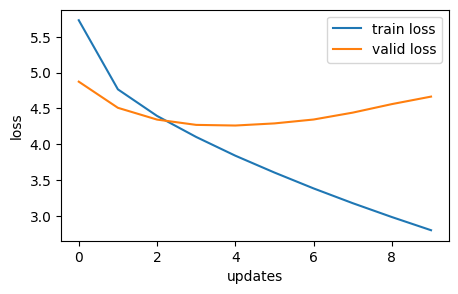

In [1231]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [1232]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 4.257 | Test PPL:  70.601 |


## 7. Test on some random news

In [1233]:
sample[0]

'Human evolution is the evolutionary process within the history of primates that led to the emergence of Homo sapiens as a distinct species of the hominid family, which includes all the great apes'

In [1234]:
sample[1]

'ဇီဝဗေဒ ပညာတွင် ဆင့်ကဲပြောင်းလဲမှုဖြစ်စဉ် သို့မဟုတ် အီဗော်လူးရှင်း ဆိုသည်မှာ သက်ရှိအစုအဝေးများတွင် တွေ့ရသော မျိုးရိုးလိုက်သည့် လက္ခဏာရပ်များ အချိန်နှင့် အမျှ ပြောင်းလဲသွားခြင်းကို ခေါ်ဆိုခြင်း ဖြစ်သည်'

In [1235]:
src_text = text_transform[SRC_LANGUAGE](sample[0]).to(device)
src_text

tensor([   2, 5420,  500,   40,    4, 2614,  777,  322,    4,  192,    6, 3480,
          23,   69,    9,    4, 2942,    6,  314,  809,   14,   10, 2931,  280,
           6,    4, 2632,  541,    5,   27, 3411,   66,    4,  312, 1292,    3],
       device='cuda:0')

In [1236]:
trg_text = text_transform[TRG_LANGUAGE](sample[1]).to(device)
trg_text

tensor([   2,  727,  166,    6, 1221,  152,   20, 1492,  236,    0,   97,    4,
          19,  471, 1784,    5,    6,  113,   27,    9, 1118,  150,   34, 3499,
           5,  130, 1166,  152,   80,   24,    7,  632,   24,   11,    4,    3],
       device='cuda:0')

In [1237]:
# print("Tokenized Source Text:", text_transform[SRC_LANGUAGE](sample['English']))
# print("Tokenized Target Text:", text_transform[TRG_LANGUAGE](sample['Burmese']))

In [1238]:
# print(trg_text)
# print([vocab_transform[TRG_LANGUAGE].lookup_token(i) for i in trg_text.squeeze().tolist()])


In [1239]:
# sample_text = "မြန်မာစာကို tokenize လုပ်မည်။"
# tokens = token_transform[TRG_LANGUAGE](sample_text)
# print("Tokenized:", tokens)

# indexed_tokens = vocab_transform[TRG_LANGUAGE](tokens)
# print("Indexed Tokens:", indexed_tokens)

In [1240]:
# type(trg_text)

In [1241]:
# text = "မြန်မာစာကို tokenize လုပ်မည်။"
# tokens = pyidaungsu.tokenize(text, form="word")
# print(tokens)

In [1242]:
# print("Tokenized:", token_transform[TRG_LANGUAGE](sample['Burmese']))
# print("Indexed Tokens:", trg_text.squeeze().tolist())
# print("Decoded Tokens:", [vocab_transform[TRG_LANGUAGE].lookup_token(i) for i in trg_text.squeeze().tolist()])

In [1243]:
# def preprocess_my_text(text):
#     text = re.sub(r"[a-zA-Z]+", "<eng>", text)  # Replace English words with placeholder
#     return text

# sample_text = preprocess_my_text("မြန်မာစာကို tokenize လုပ်မည်။")
# tokens = token_transform[TRG_LANGUAGE](sample_text)
# print("Tokenized:", tokens)


In [1244]:
src_text = src_text.reshape(1, -1)  #because batch_size is 1

In [1245]:
trg_text = trg_text.reshape(1, -1)

In [1246]:
src_text.shape, trg_text.shape

(torch.Size([1, 36]), torch.Size([1, 36]))

In [1247]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [1248]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, trg_text) #turn off teacher forcing

In [1249]:
output.shape #batch_size, trg_len, trg_output_dim

torch.Size([1, 36, 5657])

In [1250]:
# print("Attention Weights:", attentions)

Since batch size is 1, we just take off that dimension

In [1251]:
# with torch.no_grad():
#     output_logits, _ = model(src_text, trg_text)
#     output_probs = output_logits.softmax(dim=-1)  # Convert logits to probabilities
#     output_indices = output_probs.argmax(dim=-1).tolist()

#     print("Raw Predicted Indices:", output_indices)
#     print("Raw Probabilities:", output_probs.max(dim=-1)[0].tolist())

In [1252]:
# with torch.no_grad():
#     output_c2, _ = model(src_text, trg_text)
#     output_indices = output_c2.argmax(dim=-1).flatten().tolist()
#     print("Predicted Word Indices:", output_indices)

#     predicted_tokens = [vocab_transform[TRG_LANGUAGE].lookup_token(i) for i in output_indices]
#     print("Predicted Tokens:", predicted_tokens)

In [1253]:
# with torch.no_grad():
#     output_check, _ = model(src_text, trg_text)
#     predicted_tokens = [vocab_transform[TRG_LANGUAGE].lookup_token(i.item()) for i in output_check.argmax(dim=-1)[0]] # Iterate through elements of the tensor directly
#     print("Predicted Tokens:", predicted_tokens)

In [1254]:
# for batch in train_loader:
#     print("Target Tokens:", batch[2][0])  # Print first target sequence
#     break

In [1255]:
# print("Model Raw Output:", output)  # Logits before applying argmax
# print("Output Shape:", output.shape)  # Ensure correct dimensions

In [1256]:
# first_token = vocab_transform[TRG_LANGUAGE].lookup_token(0)  # Assuming 0 is the index of the first token
# print("First token in vocabulary:", first_token)

In [1257]:
output = output.squeeze(0)

In [1258]:
output.shape

torch.Size([36, 5657])

In [1259]:
# output

In [1260]:
# print(vocab_transform[TRG_LANGUAGE].lookup_token(0))  # Should print '<unk>'
# print(vocab_transform[TRG_LANGUAGE].lookup_token(1))  # Should print '<pad>'
# print(vocab_transform[TRG_LANGUAGE].lookup_token(2))  # Should print '<sos>'

We shall remove the first token since it's zeroes anyway

In [1261]:
output = output[1:]
output.shape #trg_len, trg_output_dim

torch.Size([35, 5657])

In [1262]:
# # temperature scaling
# import torch.nn.functional as F

# temperature = 2.0  # Try values between 1.5 - 3.0
# probs = F.softmax(output / temperature, dim=1)  # Scale logits to smooth out extreme values
# output_max = probs.argmax(dim=1)

Then we just take the top token with highest probabilities

In [1263]:
output_max = output.argmax(1) #returns max indices

In [1264]:
output_max

tensor([  7,  22,   0, 152,  20,   5,   5, 169,   0,   9,  19,   0,   5,   5,
          7,   0,  27,   4,   0,   0,   4, 260,   5,   7,  17, 152,  20,   4,
         11,   0,  24,  11,   4,   3,   7], device='cuda:0')

In [1265]:
# print("Vocabulary size:", len(vocab_transform[TRG_LANGUAGE]))
# print("Sample tokens:", [vocab_transform[TRG_LANGUAGE].lookup_token(i) for i in range(10)])

In [1266]:
# predicted_tokens = [vocab_transform[TRG_LANGUAGE].lookup_token(i) for i in output_max.tolist()]
# print(predicted_tokens)

In [1267]:
# print("Most common prediction index:", output_max.bincount().argmax().item())
# print("Predicted indices:", output_max.tolist())


In [1268]:
# for name, param in model.named_parameters():
#     if param.grad is not None:
#         print(f"{name} gradient mean: {param.grad.abs().mean().item()}")

In [1269]:
# for name, param in model.named_parameters():
#     if param.grad is not None:
#         print(f"{name}: {param.grad.abs().max().item()} (max gradient)")

In [1270]:
# print("Most common prediction:", output_max.bincount().argmax().item())

In [1271]:
# probs = F.softmax(output, dim=-1)
# output_max = probs.argmax(dim=-1)
# print(output_max)

Get the mapping of the target language

In [1272]:
# print("First 20 words in vocabulary:", [vocab_transform[TRG_LANGUAGE].lookup_token(i) for i in range(20)])

In [1273]:
# print([token.item() for token in output_max])  # Check raw token IDs

In [1274]:
# print(text_transform[SRC_LANGUAGE])  # Check if it prints a function

In [1275]:
# print(len(vocab_transform[SRC_LANGUAGE]))  # Source vocab size
# print(len(vocab_transform[TRG_LANGUAGE]))  # Target vocab size

In [1276]:
# unk_count = sum(1 for token in vocab_transform[TRG_LANGUAGE].get_itos() if token == '<unk>')
# print(f"Number of <unk> tokens in target vocab: {unk_count}")

In [1277]:
# print(torch.sum(output_max == 0).item())  # Count of `<unk>` predictions

In [1278]:
# unk_count = sum(1 for token in vocab_transform[TRG_LANGUAGE].get_itos() if token == '<unk>')
# print(f"Number of <UNK> tokens in target vocab: {unk_count}")

In [1279]:
# print("Raw predicted indices:", output_max.tolist())
# predicted_tokens = [vocab_transform[TRG_LANGUAGE].lookup_token(i) for i in output_max.tolist()]
# print("Predicted Tokens:", predicted_tokens)

In [1280]:
# print("Vocabulary size:", len(vocab_transform[TRG_LANGUAGE]))
# for i in range(10):  # Print first 10 words
#     print(f"Index {i}: {vocab_transform[TRG_LANGUAGE].lookup_token(i)}")

In [1281]:
# import torch.nn.functional as F

# probs = F.softmax(output, dim=-1)  # Convert logits to probabilities
# print("Softmax Output (Probabilities):")
# print(probs)

In [1282]:
# output_max = probs.argmax(dim=-1)  # Get predicted word indices
# print("Predicted Indices:", output_max.tolist())

# predicted_tokens = [vocab_transform[TRG_LANGUAGE].lookup_token(i) for i in output_max.tolist()]
# print("Predicted Tokens:", predicted_tokens)

In [1283]:
# assert SRC_PAD_IDX == PAD_IDX, "Source padding index mismatch!"
# assert TRG_PAD_IDX == PAD_IDX, "Target padding index mismatch!"

In [1284]:
# print(output[:5])  # Print first 5 timesteps of model output

In [1285]:
# unk_count = sum(1 for sentence in train for token in sentence.split() if token == '<unk>')
# total_tokens = sum(len(sentence.split()) for sentence in train)

# print(f"<unk> token frequency: {unk_count / total_tokens:.4f}")  # Should be < 0.05 (5%)

In [1286]:
# mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [1287]:
# print("Vocabulary length:", len(mapping))
# print("First 10 mappings:", mapping[:10])

In [1288]:
# print("First 10 output_max indices:", output_max[:10])

In [1289]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [1290]:
for token in output_max:
    print(mapping[token.item()])

ကို
ရေး
<unk>
ပြောင်းလဲ
မှု
များ
များ
အပင်
<unk>
သော
မှာ
<unk>
များ
များ
ကို
<unk>
ရ
သည်
<unk>
<unk>
သည်
အပြင်
များ
ကို
မှ
ပြောင်းလဲ
မှု
သည်
ဖြစ်
<unk>
ခြင်း
ဖြစ်
သည်
<eos>
ကို


## 8. Attention

Let's display the attentions to understand how the source text links with the generated text

In [1291]:
attentions.shape

torch.Size([1, 8, 36, 36])

Since there are 8 heads, we can look at just 1 head for sake of simplicity.

In [1292]:
attention = attentions[0, 0, :, :]
attention.shape

torch.Size([36, 36])

In [1293]:
src_tokens = ['<sos>'] + token_transform[SRC_LANGUAGE](sample[0]) + ['<eos>']
src_tokens

['<sos>',
 'Human',
 'evolution',
 'is',
 'the',
 'evolutionary',
 'process',
 'within',
 'the',
 'history',
 'of',
 'primates',
 'that',
 'led',
 'to',
 'the',
 'emergence',
 'of',
 'Homo',
 'sapiens',
 'as',
 'a',
 'distinct',
 'species',
 'of',
 'the',
 'hominid',
 'family',
 ',',
 'which',
 'includes',
 'all',
 'the',
 'great',
 'apes',
 '<eos>']

In [1294]:
trg_tokens = ['<sos>'] + [mapping[token.item()] for token in output_max]
trg_tokens

['<sos>',
 'ကို',
 'ရေး',
 '<unk>',
 'ပြောင်းလဲ',
 'မှု',
 'များ',
 'များ',
 'အပင်',
 '<unk>',
 'သော',
 'မှာ',
 '<unk>',
 'များ',
 'များ',
 'ကို',
 '<unk>',
 'ရ',
 'သည်',
 '<unk>',
 '<unk>',
 'သည်',
 'အပြင်',
 'များ',
 'ကို',
 'မှ',
 'ပြောင်းလဲ',
 'မှု',
 'သည်',
 'ဖြစ်',
 '<unk>',
 'ခြင်း',
 'ဖြစ်',
 'သည်',
 '<eos>',
 'ကို']

In [1295]:
import matplotlib.ticker as ticker

def display_attention(sentence, translation, attention):

    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)

    attention = attention.squeeze(1).cpu().detach().numpy()

    cax = ax.matshow(attention, cmap='bone')

    ax.tick_params(labelsize=10)

    y_ticks =  [''] + translation
    x_ticks =  [''] + sentence

    ax.set_xticklabels(x_ticks, rotation=45)
    ax.set_yticklabels(y_ticks)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

<ipython-input-1295-08ff35c238c4>:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_ticks, rotation=45)
<ipython-input-1295-08ff35c238c4>:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(y_ticks)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4096 (\N{MYANMAR LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4141 (\N{MYANMAR VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 4143 (\N{MYANMAR VOWEL SIGN U}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/

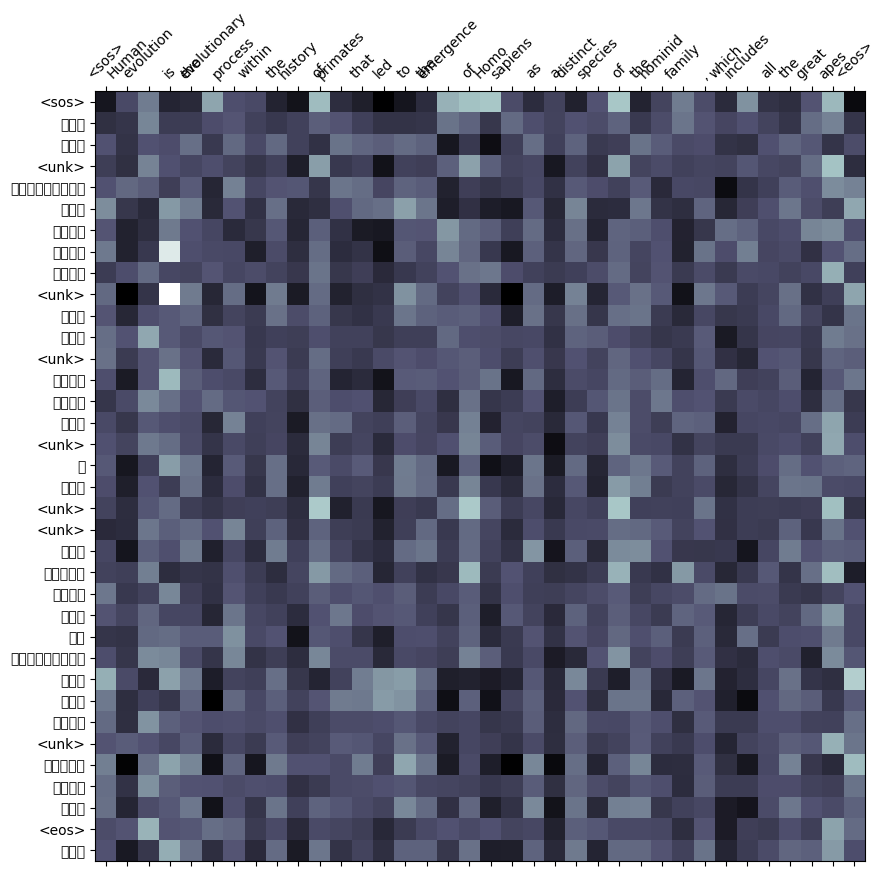

In [1296]:
display_attention(src_tokens, trg_tokens, attention)

In [1297]:
import pickle

vocab = {
    'token_transform': token_transform,
    'vocab_transform': vocab_transform,
}
pickle.dump(vocab, open('models/mtt_multiplicative.pkl', 'wb'))